In [37]:
# TS2Vec Test
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


Prepate Data.
format:
    one instance is a day with 24 points, 7 channels

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load ETTh1 data
data_path = '../data/ETTh1.csv'
df = pd.read_csv(data_path)
df.drop(columns=['date'], inplace=True)

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values)

# Partition data into windows: one instance is a day (24 points)
window_size = 24
# We use non-overlapping windows to represent each day
data = df_scaled[:(len(df_scaled) // window_size) * window_size]
data = data.reshape(-1, window_size, df.shape[1])

print(f"Data shape (B, L, C): {data.shape}")
print(f"Number of days: {data.shape[0]}")
print(f"Points per day: {data.shape[1]}")
print(f"Channels: {data.shape[2]}")

Data shape (B, L, C): (725, 24, 7)
Number of days: 725
Points per day: 24
Channels: 7


In [ ]:
from ts2vec import TS2Vec

# Initialize TS2Vec model
model = TS2Vec(
    input_dims=df.shape[1],
    output_dims=320,  # Embedding dimension
    hidden_dims=64,
    depth=10,         # Inspection width
    device=device,
    batch_size=16     # critical for instance comparing, set like 64 for larger datasets
)

# Training Process
print(f"Training TS2Vec with batch_size={model.batch_size}...")
model.fit(data, n_epochs=500, verbose=True)

# Generate representations for all windows
# result: (B, L, C) where C=64
reprs = model.encode(data)
print(f"Representation shape (Batch, Length, Dim): {reprs.shape}")

# Series representation (per window) using max pooling
series_repr = np.max(reprs, axis=1)
print(f"Series level representation shape (Batch, Dim): {series_repr.shape}")

Training TS2Vec with batch_size=16...
Epoch #0: loss=3.149832887119717
Epoch #1: loss=1.9408229351043702
Epoch #2: loss=1.7319436841540867
Epoch #3: loss=1.6129243824217054
Epoch #4: loss=1.4886912398868137
Epoch #5: loss=1.3662902341948615
Epoch #6: loss=1.2696053465207418
Epoch #7: loss=1.2364528006977504
Epoch #8: loss=1.2765466451644898
Epoch #9: loss=1.0251820577515496
Epoch #10: loss=1.0703449143303765
Epoch #11: loss=1.0474332968393962
Epoch #12: loss=1.1068639662530688
Epoch #13: loss=1.0429451002015009
Epoch #14: loss=0.9104361454645793
Epoch #15: loss=0.8978095412254333
Epoch #16: loss=0.9179337845908271
Epoch #17: loss=0.906927498181661
Epoch #18: loss=0.9490862581464979
Epoch #19: loss=0.8670942571428087
Epoch #20: loss=0.8769129905435774
Epoch #21: loss=0.9126413808928595
Epoch #22: loss=0.8466858400238885
Epoch #23: loss=0.744392806953854
Epoch #24: loss=0.7599568075603909
Epoch #25: loss=0.7288018822669983
Epoch #26: loss=0.7858754621611701
Epoch #27: loss=0.761830078230

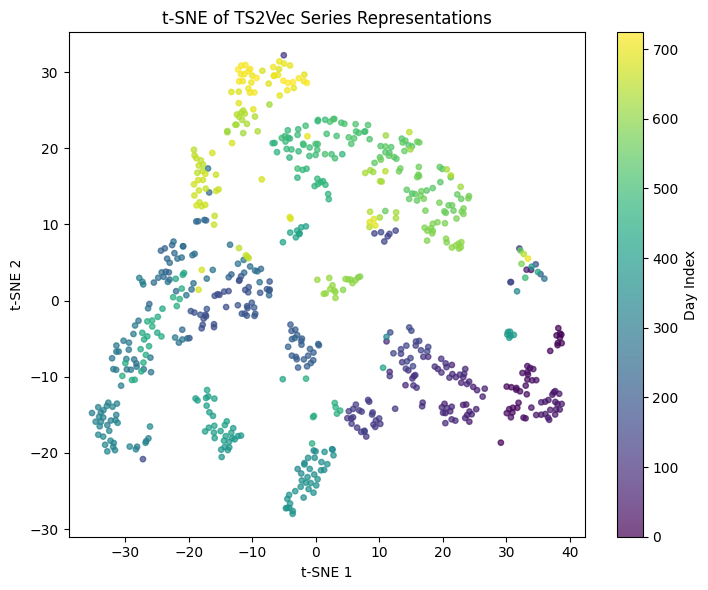

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Dimensionality reduction for series-level representations (one vector per day)
# series_repr shape: (725, 64)

# 1. PCA (linear reduction)
pca = PCA(n_components=30)
series_repr_pca = pca.fit_transform(series_repr)

# 2. t-SNE (non-linear reduction)
# Note: n_iter was renamed to max_iter in newer sklearn versions
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
series_repr_tsne = tsne.fit_transform(series_repr)

# Plotting the results
plt.figure(figsize=(14, 6))
# t-SNE Plot
plt.subplot(1, 2, 2)
sc2 = plt.scatter(series_repr_tsne[:, 0], series_repr_tsne[:, 1], 
                  c=np.arange(len(series_repr_tsne)), cmap='viridis', s=15, alpha=0.7)
plt.colorbar(sc2, label='Day Index')
plt.title('t-SNE of TS2Vec Series Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

d:\Projects\MOMENT_Test\.venv\Lib\site-packages\sklearn\cluster\_hdbscan\hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(


Estimated number of clusters: 11
Estimated number of noise points: 261/725


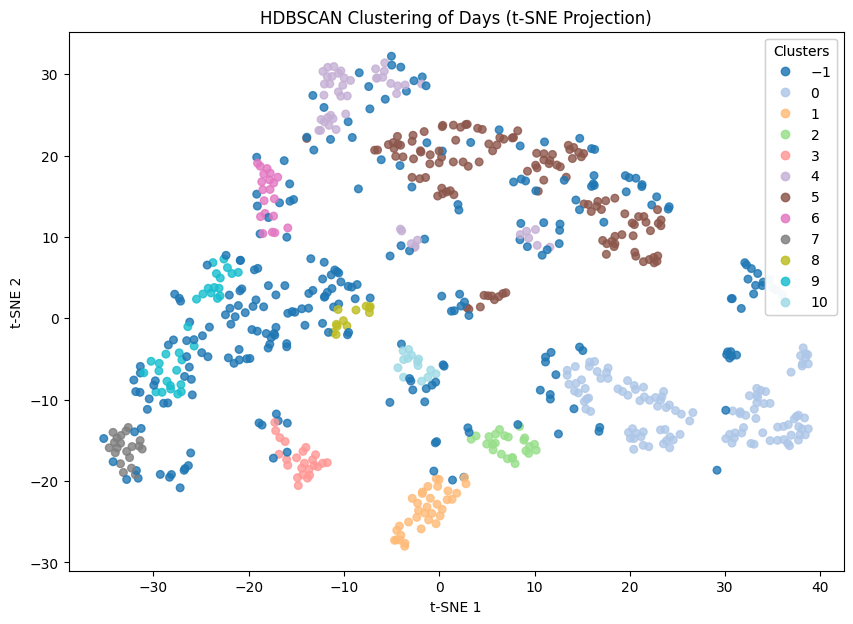

In [46]:
from sklearn.cluster import HDBSCAN

# Perform HDBSCAN clustering
# min_cluster_size: Minimum number of samples in a group to be considered a cluster
clusterer = HDBSCAN(min_cluster_size=10, min_samples=5)
cluster_labels = clusterer.fit_predict(series_repr)

# Number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}/{len(series_repr)}")

# Visualize the clusters on t-SNE projection
plt.figure(figsize=(10, 7))
ax = plt.gca()
scatter = ax.scatter(series_repr_tsne[:, 0], series_repr_tsne[:, 1], 
                      c=cluster_labels, cmap='tab20', s=30, alpha=0.8)

# Add a legend for clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax.add_artist(legend1)

plt.title('HDBSCAN Clustering of Days (t-SNE Projection)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Number of days in Cluster 1: 35


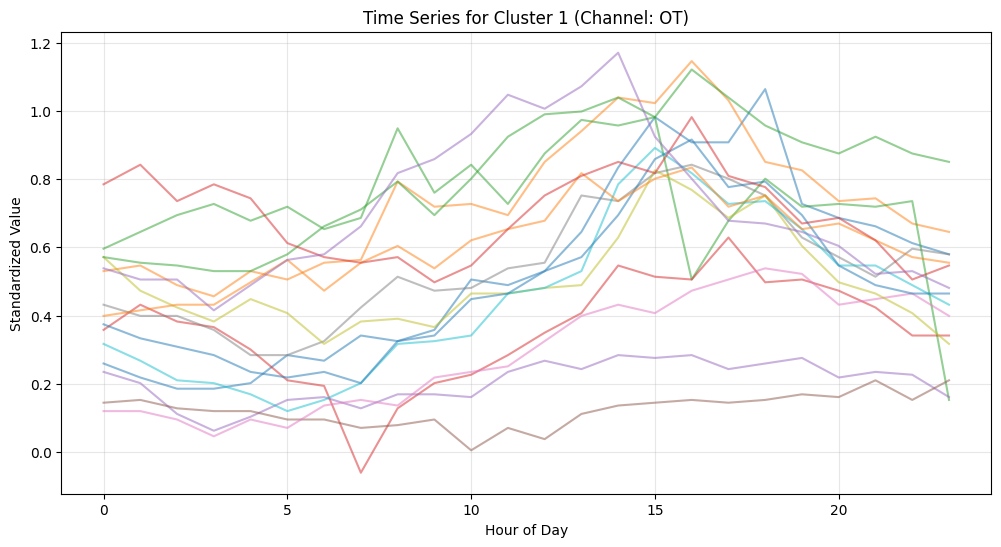

In [47]:
# Visualize specific days in Cluster 1
target_cluster = 1
cluster_indices = np.where(cluster_labels == target_cluster)[0]

print(f"Number of days in Cluster {target_cluster}: {len(cluster_indices)}")

# Plotting the raw data (Standardized) for the days in this cluster
# Let's plot the 'OT' (Oil Temperature) channel - index 6
channel_idx = 6 
channel_name = df.columns[channel_idx]

plt.figure(figsize=(12, 6))
for idx in cluster_indices[:15]: # Show first 15 days to avoid overcrowding
    plt.plot(data[idx, :, channel_idx], alpha=0.5, label=f"Day {idx}")

plt.title(f'Time Series for Cluster {target_cluster} (Channel: {channel_name})')
plt.xlabel('Hour of Day')
plt.ylabel('Standardized Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2) 
plt.grid(True, alpha=0.3)
plt.show()

Number of days in Cluster 2: 24


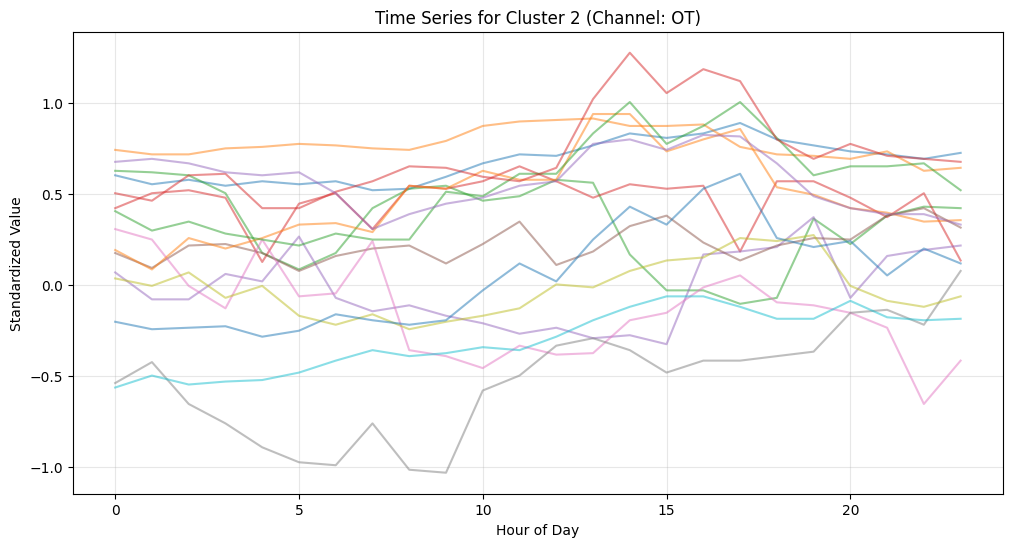

In [48]:
# Visualize specific days in Cluster 1
target_cluster = 2
cluster_indices = np.where(cluster_labels == target_cluster)[0]

print(f"Number of days in Cluster {target_cluster}: {len(cluster_indices)}")

# Plotting the raw data (Standardized) for the days in this cluster
# Let's plot the 'OT' (Oil Temperature) channel - index 6
channel_idx = 6 
channel_name = df.columns[channel_idx]

plt.figure(figsize=(12, 6))
for idx in cluster_indices[:15]: # Show first 15 days to avoid overcrowding
    plt.plot(data[idx, :, channel_idx], alpha=0.5, label=f"Day {idx}")

plt.title(f'Time Series for Cluster {target_cluster} (Channel: {channel_name})')
plt.xlabel('Hour of Day')
plt.ylabel('Standardized Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2) 
plt.grid(True, alpha=0.3)
plt.show()

Number of days in Cluster 3: 24


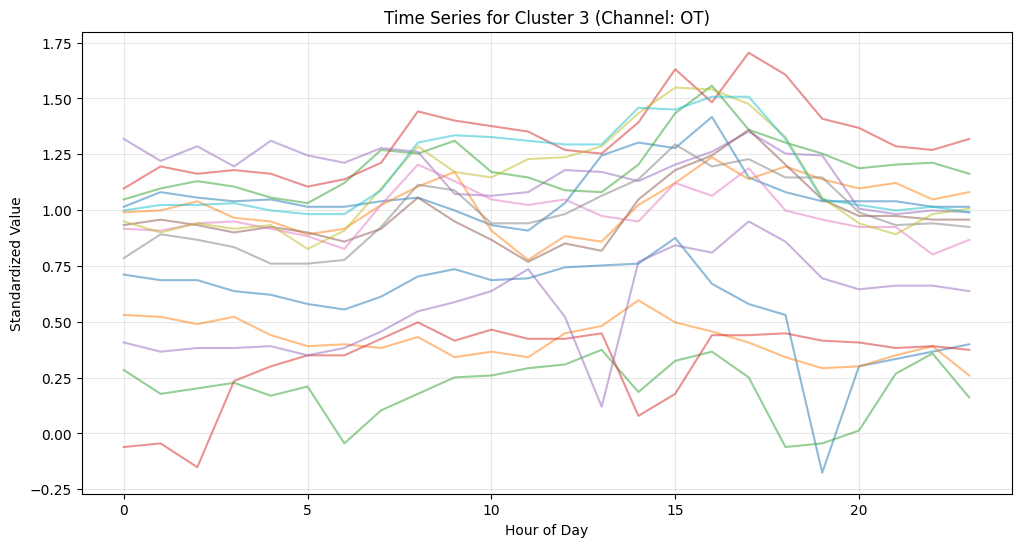

In [49]:
# Visualize specific days in Cluster 1
target_cluster = 3
cluster_indices = np.where(cluster_labels == target_cluster)[0]

print(f"Number of days in Cluster {target_cluster}: {len(cluster_indices)}")

# Plotting the raw data (Standardized) for the days in this cluster
# Let's plot the 'OT' (Oil Temperature) channel - index 6
channel_idx = 6 
channel_name = df.columns[channel_idx]

plt.figure(figsize=(12, 6))
for idx in cluster_indices[:15]: # Show first 15 days to avoid overcrowding
    plt.plot(data[idx, :, channel_idx], alpha=0.5, label=f"Day {idx}")

plt.title(f'Time Series for Cluster {target_cluster} (Channel: {channel_name})')
plt.xlabel('Hour of Day')
plt.ylabel('Standardized Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2) 
plt.grid(True, alpha=0.3)
plt.show()